# Préparation des données

Importation des librairies

In [105]:
import pandas as pd
import sklearn as sk
import numpy as np
from sklearn.metrics import accuracy_score,recall_score,precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import json
import joblib

Importer le fichier CSV

In [90]:
from google.colab import drive
drive.mount("/content/gdrive/")

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [91]:
data = pd.read_csv("/content/gdrive/MyDrive/Projet_IA/data.csv", sep=";")
data = pd.DataFrame(data)

Préparation des données

In [92]:
data.drop(columns = ['Num_Acc', 'num_veh', 'id_usa', 'date', 'ville', 'id_code_insee', 'descr_cat_veh', 'descr_agglo', 'descr_athmo', 'descr_lum', 'descr_etat_surf', 'description_intersection', 'descr_dispo_secu', 'descr_grav', 'descr_motif_traj', 'descr_type_col', 'an_nais', 'place', 'dept', 'region', 'CODE_REG', 'weeks', 'month', 'days', 'intersection_num', 'motif_num', 'collision_num'], inplace = True)

In [93]:
print(data.head())

    latitude  longitude  age  weight  gravity  hours  athmo_num  \
0  47.487718  -1.216426   40    7500        0      8          6   
1  45.595814   5.655880   50    2000        0     11          5   
2  45.595814   5.655880   49    1240        0     17          5   
3  42.793565   3.002079   52    1240        0     20          4   
4  45.970826   0.050529   58    1240        0     17          0   

   etat_surf_num  lum_num  agglo_num  
0              7        1          1  
1              5        0          1  
2              5        0          1  
3              6        4          1  
4              0        0          1  


In [94]:
from sklearn import *

#Pour accélérer la recherche des meilleurs paramètres, on ne conserve que 10% des données
#Pour appliquer les modèles on gardera la totalité des données
#data = data.groupby("gravity").apply(lambda x: x.sample(frac=0.1))

#on divise les labels
x, y = data.drop(columns=["gravity"]), data.gravity

#découpage de la base d'entrainement et de test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.8)

# PCA

Analayse en Composante Principale

In [ ]:
from sklearn.preprocessing import StandardScaler

#liste des classes conservées
features = ['athmo_num', 'etat_surf_num', 'lum_num', 'weight', 'age']
x = data.loc[:, features].values
y = data.loc[:,['gravity']].values

scaler = StandardScaler()
x = scaler.fit_transform(x)

#application de l'analyse en composante principale
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
x_reduit = pca.fit_transform(x)

#création du nouveau dataframe avec les 2 classes obtenues via PCA et la gravité de chaque index
principalDf = pd.DataFrame(data = x_reduit, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, data[['gravity']]], axis = 1)

Visualisation

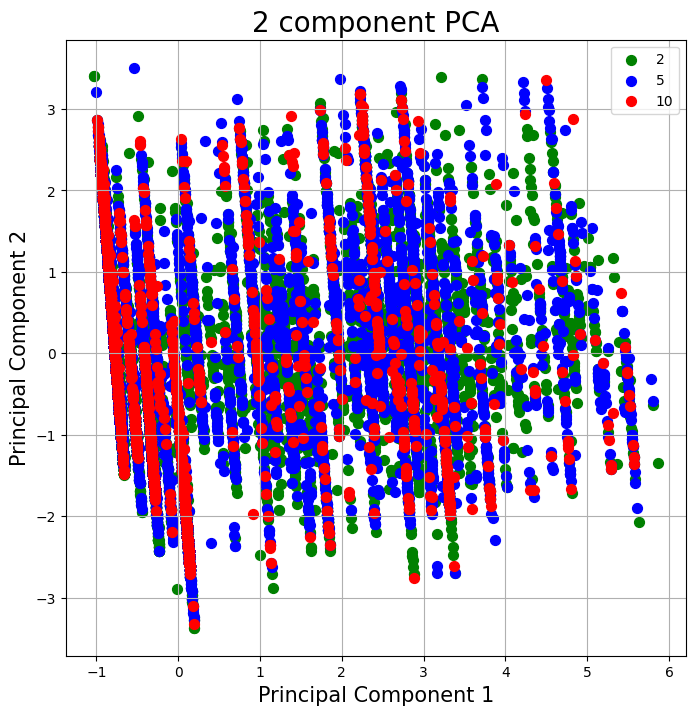

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

#on retire volontairement les accidents de gravité 0 (indemne) pour que l'affichage soit plus clair
targets = [2, 5, 10]
colors = ['g', 'b', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['gravity'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

# Support Vector Machine

In [101]:
from sklearn import svm

Détermination des paramètres optimaux

In [102]:
from sklearn.model_selection import GridSearchCV

#liste des paramètres à tester et leurs valeurs
parameters = {
    'C': [1, 10],
    'kernel': ['rbf'],
    'gamma': ['scale', 'auto']
}

scaler = StandardScaler()
x = scaler.fit_transform(x)

svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(x_train, y_train)

#affichage des meilleurs paramètres
print(clf.best_params_)

0.5402125203693645   {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


0.5402125203693645   0.2686063840095357   0.3388147941557012


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


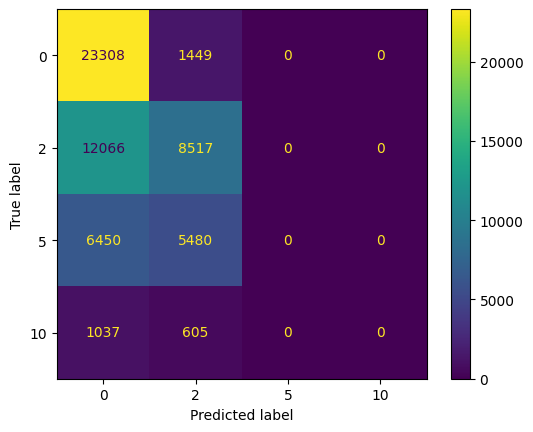

In [107]:
svc = svm.SVC(C=10,kernel='rbf',gamma='scale')
svc.fit(x_train, y_train)
joblib.dump(svc, "/content/gdrive/MyDrive/Projet_IA/SVC.joblib")

svc_pred = svc.predict(x_test)

#scores d’échantillons bien classifiés sur le jeu de données de test
accuracy_svc = accuracy_score(y_test, svc_pred)
precision_svc = precision_score(y_test, svc_pred, average='macro')
recall_svc = recall_score(y_test, svc_pred, average='macro')
print(accuracy_svc," ",precision_svc," ",recall_svc)

#matrice de confusion de notre modèle
cm = confusion_matrix(y_test, svc_pred, labels=svc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc.classes_)
disp.plot()

# Random forest

In [99]:
from sklearn.ensemble import RandomForestClassifier

Détermination des paramètres optimaux

In [100]:
from sklearn.model_selection import GridSearchCV

#liste des paramètres à tester et leurs valeurs
parameters = {
    'max_features': ['sqrt'],
    'max_depth': [None],
    'n_estimators': [200, 1000, 2000]
}

raf = RandomForestClassifier()
clf = GridSearchCV(raf, parameters)
clf.fit(x_train, y_train)

#affichage des meilleurs paramètres
print(clf.best_params_)

0.5651819663226507   {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 2000}


0.5647406300923411   0.44130081834482243   0.41024491410044484


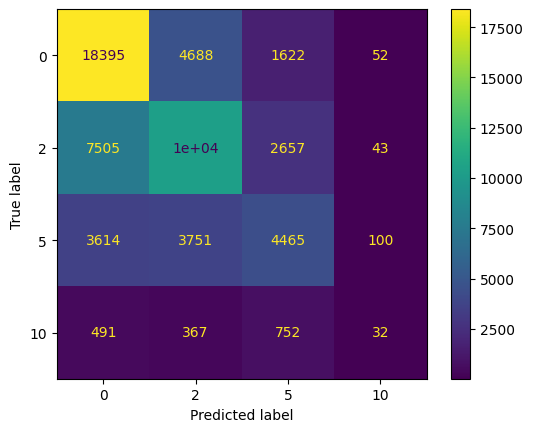

In [108]:
raf = RandomForestClassifier(max_depth=None, max_features='sqrt',n_estimators=1000)
raf.fit(x_train, y_train)
joblib.dump(raf, "/content/gdrive/MyDrive/Projet_IA/random_forest.joblib")

raf_pred = raf.predict(x_test)

#scores d’échantillons bien classifiés sur le jeu de données de test
accuracy_raf = accuracy_score(y_test, raf_pred)
precision_raf = precision_score(y_test, raf_pred, average='macro')
recall_raf = recall_score(y_test, raf_pred, average='macro')
print(accuracy_raf," ",precision_raf," ",recall_raf)

#matrice de confusion de notre modèle
cm = confusion_matrix(y_test, raf_pred, labels=raf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=raf.classes_)
disp.plot()

# Multilayer Perceptron

In [95]:
from sklearn.neural_network import MLPClassifier

Détermination des paramètres optimaux

In [97]:
from sklearn.model_selection import GridSearchCV

#liste des paramètres à tester et leurs valeurs
parameters = {
    'hidden_layer_sizes' : [150,100,50],
}

mlp = MLPClassifier()
clf = GridSearchCV(mlp, parameters)
clf.fit(x_train, y_train)

#affichage des meilleurs paramètres
print(clf.best_params_)

0.3044541010320478   {'hidden_layer_sizes': 100}


0.4524714828897338   0.39024936138317484   0.3892831442370624


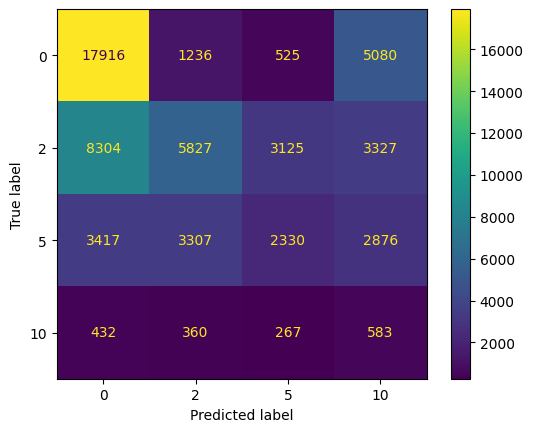

In [109]:
mlp = MLPClassifier(hidden_layer_sizes=50)
mlp.fit(x_train, y_train)
joblib.dump(mlp, "/content/gdrive/MyDrive/Projet_IA/MLP.joblib")

mlp_pred = mlp.predict(x_test)

#scores d’échantillons bien classifiés sur le jeu de données de test
accuracy_mlp = accuracy_score(y_test, mlp_pred)
precision_mlp = precision_score(y_test, mlp_pred, average='macro')
recall_mlp = recall_score(y_test, mlp_pred, average='macro')
print(accuracy_mlp," ",precision_mlp," ",recall_mlp)

#matrice de confusion de notre modèle
cm = confusion_matrix(y_test, mlp_pred, labels=mlp.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp.classes_)
disp.plot()

# Comparaison des modèles

In [110]:
accuracy_max = max([accuracy_svc, accuracy_raf, accuracy_mlp])
if accuracy_max == accuracy_svc:
  print("Le meilleur modèle est Support Vector Machine")
elif accuracy_max == accuracy_raf:
  print("Le meilleur modèle est Random Forest")
else:
  print("Le meilleur modèle est Multilayer Perceptron")
print(accuracy_max,"% des prédictions sont bonnes")

Le meilleur modèle est Random Forest
0.5647406300923411 % des prédictions sont bonnes


# Export JSON

In [87]:
def highLevel(data, modele):
    #transformation des données d'entrée pour être utilisée sous forme de Dataframe
    if type(data) == type(""):
      data = data.replace(' ', '')
      data = data.replace('[', '')
      data = data.replace(']', '')
      data = data.split(',')

    d = {
      "latitude" : [data[0]],
      "longitude" : [data[1]],
      "age" : [data[2]],
      "weight" : [data[3]],
      "hours" : [data[4]],
      "athmo_num" : [data[5]],
      "etat_surf_num" : [data[6]],
      "lum_num" : [data[7]],
      "agglo_num" : [data[8]]
    }
    test = pd.DataFrame(data=d)

    #chargement du modèle
    load_modele = joblib.load(modele)

    #création et envoie du JSON
    return_dict = {"gravity" : str(load_modele.predict(test)[0])}
    json_object = json.dumps(return_dict, indent = 4)
    return json_object

#test de la fonction de création du JSON
exemple = "[47.16, 2.15, 21, 1, 09, 1, 1, 1, 1]"
highLevel(exemple, "/content/gdrive/MyDrive/Projet_IA/random_forest.joblib")

'{\n    "gravity": "0"\n}'